In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import sklearn
!pip install pgmpy
import pgmpy
from sklearn.preprocessing import KBinsDiscretizer
from copy import  copy
import networkx as nx
from sklearn import preprocessing
from sklearn.metrics import accuracy_score


from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BDeuScore, K2Score, BicScore
from pgmpy.models import BayesianModel
from pgmpy.sampling import BayesianModelSampling
from pgmpy.inference import VariableElimination
from pgmpy.base import DAG

     |████████████████████████████████| 337kB 8.6MB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
path_to_file = '/content/drive/My Drive/album_ratings.csv'
source_df = pd.read_csv(path_to_file, engine='python')
source_df.dropna(inplace=True)
source_df.reset_index(inplace=True, drop=True)
del source_df["Artist"]
del source_df["Title"]
del source_df["Label"]
del source_df["Genre"]

source_df

,Release Month,Release Day,Release Year,Format,Metacritic Critic Score,Metacritic Reviews,Metacritic User Score,Metacritic User Reviews,AOTY Critic Score,AOTY Critic Reviews,AOTY User Score,AOTY User Reviews
0,March,3,2009,LP,79.0,31.0,8.7,31.0,79,25,78,55
1,February,17,2009,LP,70.0,14.0,8.4,7.0,73,11,73,8
2,January,20,2009,LP,89.0,36.0,8.5,619.0,92,30,87,1335
3,January,27,2009,LP,72.0,29.0,7.9,101.0,70,23,66,38
4,January,20,2009,LP,79.0,29.0,8.7,47.0,74,24,78,44
...,...,...,...,...,...,...,...,...,...,...,...,...
7937,October,13,2017,LP,81.0,6.0,5.6,29.0,80,4,76,4
7938,May,12,2012,LP,81.0,6.0,8.8,4.0,75,2,70,1
7939,June,25,2013,LP,73.0,5.0,8.4,7.0,74,4,71,2
7940,September,24,2002,LP,60.0,10.0,7.0,4.0,70,2,90,1


In [ ]:
from sklearn.preprocessing import LabelEncoder
import sklearn
def code_categories(data: pd.DataFrame, method: str, columns: list) -> (pd.DataFrame, dict):
  data = data.dropna()
  data.reset_index(inplace=True, drop=True)
  d_data = data.copy()
  encoder_dict = dict()
  if method == 'label':
    for column in columns:
      le = sklearn.preprocessing.LabelEncoder()
      d_data[column] = le.fit_transform(d_data[column].values)
      mapping = dict(zip(le.classes_, range(len(le.classes_))))
      encoder_dict[column] = mapping
  elif method == 'onehot':
    d_data = pd.get_dummies(d_data, columns=columns)
  return d_data, encoder_dict

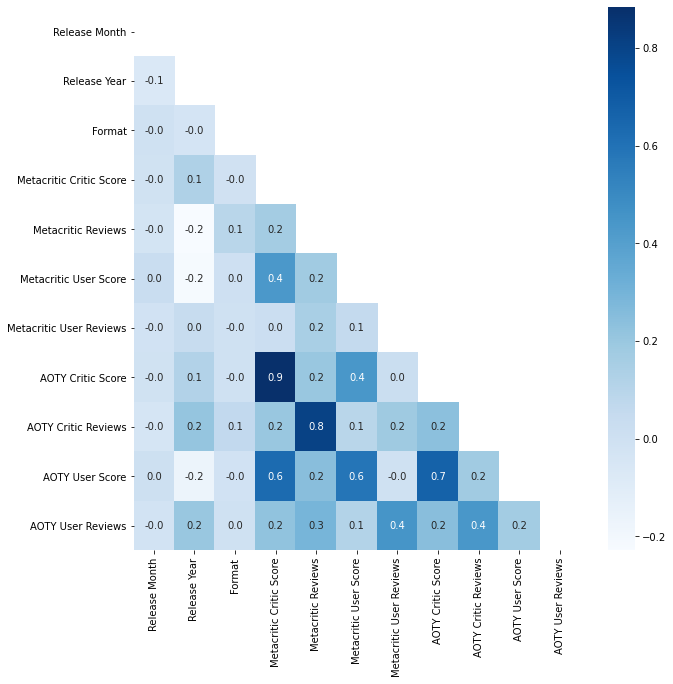

In [ ]:
# Building a correlation matrix of features
X = source_df
cat_params = ['Release Month', 'Format']
X, code_dict = code_categories(X, 'label', cat_params)

dataset = X
corr = dataset.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(corr, mask = mask, annot=True, fmt= '.1f', ax = ax, cmap = 'Blues')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

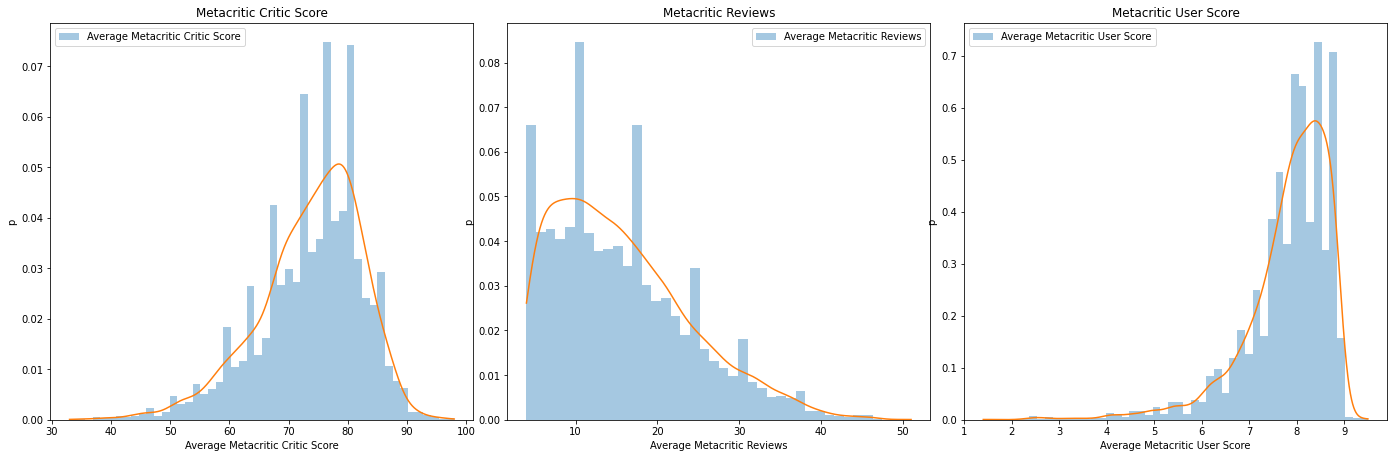

In [ ]:
# Target: Metacritic Critic Score, Metacritic Reviews,	Metacritic User Score
# Predicts: Rest without Genre

# Step 2: Using univariate parametric distributions that were fitted in Lab#2 make sampling of chosen target variables. Use for this 2 different sampling methods

plt.figure(figsize=(20, 7))
plt.subplot(1, 3, 1)

kernel = scipy.stats.gaussian_kde(source_df['Metacritic Critic Score'])

min_amount, max_amount = source_df['Metacritic Critic Score'].min(), source_df['Metacritic Critic Score'].max()
x = np.linspace(min_amount, max_amount, len(source_df))
kde_values1 = kernel(x)

sns.distplot(source_df['Metacritic Critic Score'], kde=False, norm_hist=True, label=f'Average Metacritic Critic Score')
plt.title('Metacritic Critic Score')

plt.plot(x, kde_values1)

plt.ylabel('p')
plt.xlabel('Average Metacritic Critic Score')
plt.legend()
plt.tight_layout(pad=3.0)


plt.subplot(1, 3, 2)
kernel = scipy.stats.gaussian_kde(source_df['Metacritic Reviews'])

min_amount, max_amount = source_df['Metacritic Reviews'].min(), source_df['Metacritic Reviews'].max()
x = np.linspace(min_amount, max_amount, len(source_df))
kde_values2 = kernel(x)

sns.distplot(source_df['Metacritic Reviews'], kde=False, norm_hist=True, label=f'Average Metacritic Reviews')
plt.title('Metacritic Reviews')
plt.plot(x, kde_values2)
plt.ylabel('p')
plt.xlabel('Average Metacritic Reviews')
plt.legend()


plt.subplot(1, 3, 3)
kernel = scipy.stats.gaussian_kde(source_df['Metacritic User Score'])

min_amount, max_amount = source_df['Metacritic User Score'].min(), source_df['Metacritic User Score'].max()
x = np.linspace(min_amount, max_amount, len(source_df))
kde_values3 = kernel(x)

sns.distplot(source_df['Metacritic User Score'], kde=False, norm_hist=True, label=f'Average Metacritic User Score')
plt.title('Metacritic User Score')
plt.plot(x, kde_values3)
plt.ylabel('p')
plt.xlabel('Average Metacritic User Score')
plt.legend()
plt.show()

In [ ]:
# Step 2: sampling
#inverse-transform sampling
def ITsampling(num_of_samples, data):
  u = np.random.uniform(size=num_of_samples)
  params = scipy.stats.lognorm.fit(data)
  samples = scipy.stats.lognorm.ppf(u, *params)
  return np.array(samples)

def plot_ITsamples(data, samples, title='Inverse Transform sampling'):
  plt.hist(samples, density=True, bins=int(1+3.32*np.log10(len(samples))), color='y', alpha = 0.5)
  plt.hist(data, density=True, bins=int(1+3.32*np.log10(len(data))), color='c', alpha = 0.3)
  plt.xlim(min(data), max(data))
  x_vals = np.unique(np.array(sorted(data)))
  params = scipy.stats.lognorm.fit(data)
  f_vals = [scipy.stats.lognorm.pdf(x, *params) for x in x_vals]
  plt.plot(x_vals, f_vals, 'r', linewidth=2)
  plt.legend(['theoretical pdf', 'sampled data', 'initial data'])
  plt.title(title)
  plt.show()

# Accept-Reject sampling
#normal PDF
def norm_pdf(x, mu, sigma):
  return 1/np.sqrt(2*np.pi)/sigma * np.exp(-0.5*((x-mu)/sigma)**2)

def search_M(data, mu, sigm):
  x_vals = np.unique(np.array(sorted(data)))
  params = scipy.stats.norm.fit(data)
  f_vals = [scipy.stats.norm.pdf(x, *params) for x in x_vals]
  g_vals = norm_pdf(x_vals, mu, sigm)
  M = 1
  while np.where(g_vals*M < f_vals)[0].shape[0] > 0:
    M += 0.1
  plt.figure(figsize=(10,4))
  plt.plot(x_vals, f_vals)
  plt.plot(x_vals, M*g_vals)
  plt.xlabel('x', fontsize=20)
  plt.ylabel('Density', fontsize=20)
  plt.legend(['t(x)', 'S*h(x)'], fontsize=20)
  plt.title("M=%.2f"%M, fontsize=20)
  plt.show()
  return M

def AR_sampling(num_of_samples, data, mu, sigma, M):
  #collect all accepted samples here
  samples = []
  #try this many candidates
  for _ in range(num_of_samples):
    #sample a candidate
    candidate = np.random.normal(mu, sigma)
    #calculate probability of accepting this candidate
    params = scipy.stats.norm.fit(data)
    prob_accept = scipy.stats.norm.pdf(candidate, *params) / (M*norm_pdf(candidate, mu, sigma))
    #accept with the calculated probability
    if np.random.random() < prob_accept:
      samples.append(candidate)
      # print("Num Samples Collected: %s"%len(samples))
      # print("Efficiency: %s"%round(len(samples) / num_of_samples, 3))
  return samples

def plot_ARsamples(data, samples, title='Accept-Reject sampling'):
  plt.figure(figsize=(10,4))
  plt.hist(samples, bins=200, density=True)
  plt.xlabel('x', fontsize=20)
  plt.xlabel('Density', fontsize=20)
  x_vals = np.unique(np.array(sorted(data)))
  params = scipy.stats.norm.fit(data)
  f_vals = [scipy.stats.norm.pdf(x, *params) for x in x_vals]
  plt.plot(x_vals, f_vals, linewidth=2)
  plt.xlim(min(data) - 1, max(data) + 1)
  plt.show()

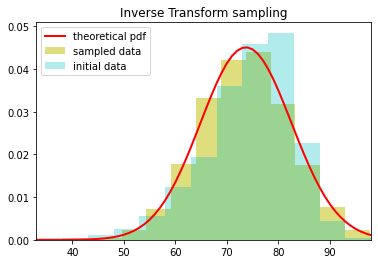

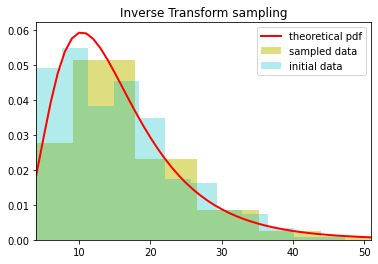

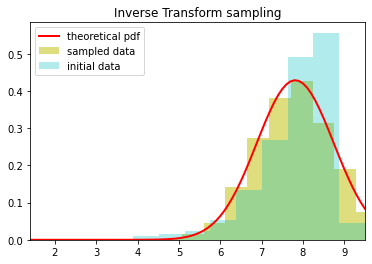

In [ ]:
# Inverse transform sampling of target variables
samples_data = ITsampling(10000, source_df['Metacritic Critic Score'])
plot_ITsamples(source_df['Metacritic Critic Score'], samples_data, title='Inverse Transform sampling')

samples_data = ITsampling(10000, source_df['Metacritic Reviews'])
plot_ITsamples(source_df['Metacritic Reviews'], samples_data, title='Inverse Transform sampling')

samples_data = ITsampling(10000, source_df['Metacritic User Score'])
plot_ITsamples(source_df['Metacritic User Score'], samples_data, title='Inverse Transform sampling')

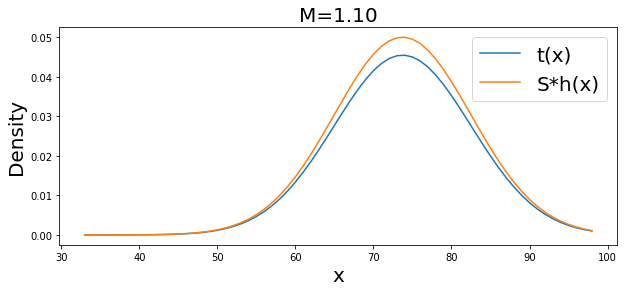

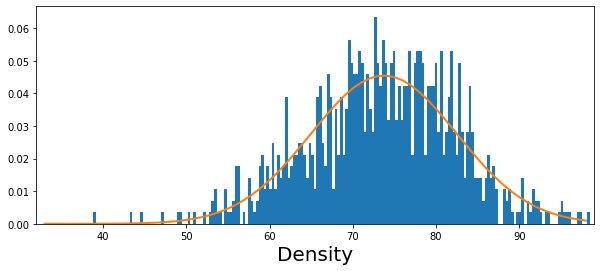

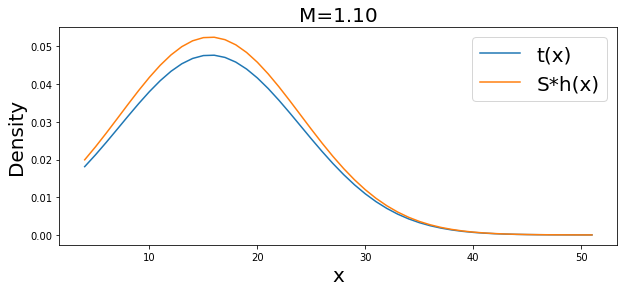

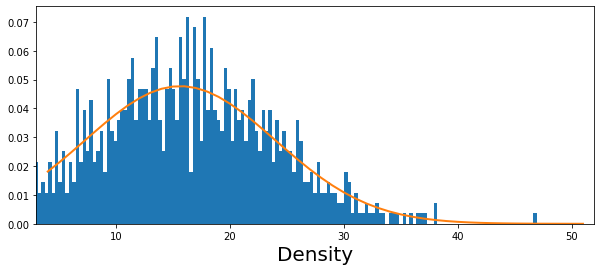

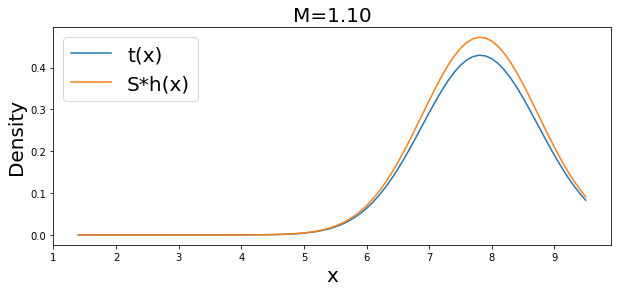

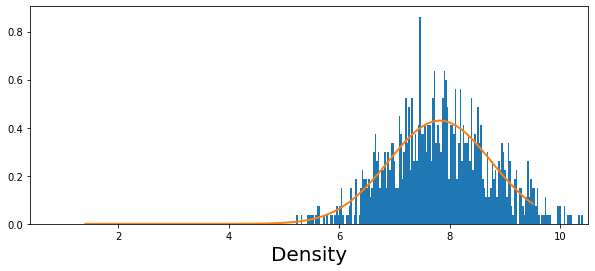

In [ ]:
# Accept-Reject sampling of chosen target variables
import math
M1 = search_M(source_df['Metacritic Critic Score'], np.mean(source_df['Metacritic Critic Score']), math.sqrt(np.var(source_df['Metacritic Critic Score'])))
samples_data = AR_sampling(1000, source_df['Metacritic Critic Score'],  np.mean(source_df['Metacritic Critic Score']), math.sqrt(np.var(source_df['Metacritic Critic Score'])), M1)
plot_ARsamples(source_df['Metacritic Critic Score'], samples_data, title='Accept-Reject sampling')

M2 = search_M(source_df['Metacritic Reviews'],  np.mean(source_df['Metacritic Reviews']), math.sqrt(np.var(source_df['Metacritic Reviews'])))
samples_data = AR_sampling(1000, source_df['Metacritic Reviews'],  np.mean(source_df['Metacritic Reviews']), math.sqrt(np.var(source_df['Metacritic Reviews'])), M2)
plot_ARsamples(source_df['Metacritic Reviews'], samples_data, title='Accept-Reject sampling')

M3 = search_M(source_df['Metacritic User Score'],  np.mean(source_df['Metacritic User Score']), math.sqrt(np.var(source_df['Metacritic User Score'])))
samples_data = AR_sampling(1000, source_df['Metacritic User Score'], np.mean(source_df['Metacritic User Score']), math.sqrt(np.var(source_df['Metacritic User Score'])), M3)
plot_ARsamples(source_df['Metacritic User Score'], samples_data, title='Accept-Reject sampling')

In [ ]:
# Step 4: Build a Bayesian network for chosen set of variables. Choose its structure on the basis 
# of multivariate analysis and train distributions in nodes using chosen algorithm
from sklearn import preprocessing

# Data Preprocessing 
# Target: Metacritic Critic Score, Metacritic Reviews,	Metacritic User Score
# Predicts: Rest without Genre

for column in ['Format','Release Month', 'Release Year']:
    le = preprocessing.LabelEncoder()
    source_df[column] = le.fit_transform(source_df[column].values)

source_df

,Release Month,Release Day,Release Year,Format,Metacritic Critic Score,Metacritic Reviews,Metacritic User Score,Metacritic User Reviews,AOTY Critic Score,AOTY Critic Reviews,AOTY User Score,AOTY User Reviews
0,7,3,10,1,79.0,31.0,8.7,31.0,79,25,78,55
1,3,17,10,1,70.0,14.0,8.4,7.0,73,11,73,8
2,4,20,10,1,89.0,36.0,8.5,619.0,92,30,87,1335
3,4,27,10,1,72.0,29.0,7.9,101.0,70,23,66,38
4,4,20,10,1,79.0,29.0,8.7,47.0,74,24,78,44
...,...,...,...,...,...,...,...,...,...,...,...,...
7937,10,13,18,1,81.0,6.0,5.6,29.0,80,4,76,4
7938,8,12,13,1,81.0,6.0,8.8,4.0,75,2,70,1
7939,6,25,14,1,73.0,5.0,8.4,7.0,74,4,71,2
7940,11,24,3,1,60.0,10.0,7.0,4.0,70,2,90,1


In [ ]:
transformed_data = copy(source_df)
est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
data_discrete = est.fit_transform(source_df.values[:,4:12])
transformed_data[['Metacritic Critic Score',	'Metacritic Reviews',	'Metacritic User Score',	'Metacritic User Reviews',	'AOTY Critic Score', 'AOTY Critic Reviews', 'AOTY User Score', 'AOTY User Reviews']] = data_discrete

In [ ]:
targetlist = [(x, y) for x in transformed_data.columns.to_list() for y in ['Metacritic Critic Score', 'Metacritic Reviews',	'Metacritic User Score'] if x != y]
targetlist

[('Release Month', 'Metacritic Critic Score'),
 ('Release Month', 'Metacritic Reviews'),
 ('Release Month', 'Metacritic User Score'),
 ('Release Day', 'Metacritic Critic Score'),
 ('Release Day', 'Metacritic Reviews'),
 ('Release Day', 'Metacritic User Score'),
 ('Release Year', 'Metacritic Critic Score'),
 ('Release Year', 'Metacritic Reviews'),
 ('Release Year', 'Metacritic User Score'),
 ('Format', 'Metacritic Critic Score'),
 ('Format', 'Metacritic Reviews'),
 ('Format', 'Metacritic User Score'),
 ('Metacritic Critic Score', 'Metacritic Reviews'),
 ('Metacritic Critic Score', 'Metacritic User Score'),
 ('Metacritic Reviews', 'Metacritic Critic Score'),
 ('Metacritic Reviews', 'Metacritic User Score'),
 ('Metacritic User Score', 'Metacritic Critic Score'),
 ('Metacritic User Score', 'Metacritic Reviews'),
 ('Metacritic User Reviews', 'Metacritic Critic Score'),
 ('Metacritic User Reviews', 'Metacritic Reviews'),
 ('Metacritic User Reviews', 'Metacritic User Score'),
 ('AOTY Critic S

In [ ]:
hc = HillClimbSearch(transformed_data, scoring_method=K2Score(transformed_data))

best_model_new = hc.estimate(black_list=targetlist)

  0%|          | 14/1000000 [00:02<50:05:20,  5.55it/s]


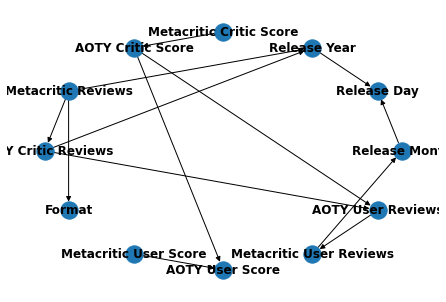

In [ ]:
G_K2 = nx.DiGraph()
G_K2.add_edges_from(best_model_new.edges())
pos = nx.layout.circular_layout(G_K2)
nx.draw(G_K2, pos, with_labels=True,font_weight='bold')

In [ ]:
def sampling (bn: DAG, data: pd.DataFrame, n: int = 100):
    bn_new = BayesianModel(bn.edges())
    bn_new.fit(data)
    sampler = BayesianModelSampling(bn_new)
    sample = sampler.forward_sample(size=n, return_type='dataframe')
    return sample

In [ ]:
# Train dist in nodes

sample_K2 = sampling(best_model_new, transformed_data, 46193)

Generating for node: AOTY User Score: 100%|██████████| 12/12 [00:03<00:00,  3.15it/s]


In [ ]:
sample_K2[['Metacritic Critic Score',	'Metacritic Reviews',	'Metacritic User Score',	'Metacritic User Reviews',	'AOTY Critic Score',	'AOTY Critic Reviews',	'AOTY User Score', 'AOTY User Reviews']] = est.inverse_transform(sample_K2[['Metacritic Critic Score',	'Metacritic Reviews',	'Metacritic User Score',	'Metacritic User Reviews',	'AOTY Critic Score',	'AOTY Critic Reviews',	'AOTY User Score', 'AOTY User Reviews']].values)

In [ ]:
def draw_comparative_hist (parametr: str, original_data: pd.DataFrame, data_sampled: pd.DataFrame):
    final_df = pd.DataFrame()
    df1 = pd.DataFrame()
    df1[parametr] = original_data[parametr]
    df1['Data'] = 'Original data'
    df1['Probability'] = df1[parametr].apply(lambda x: (df1.groupby(parametr)[parametr].count()[x])/original_data.shape[0])
    df2 = pd.DataFrame()
    df2[parametr] = data_sampled[parametr]
    df2['Data'] = 'Synthetic data'
    df2['Probability'] = df2[parametr].apply(lambda x: (df2.groupby(parametr)[parametr].count()[x])/data_sampled.shape[0])
    final_df = pd.concat([df1, df2])
    sns.barplot(x=parametr, y="Probability", hue="Data", data=final_df)
    plt.show()			

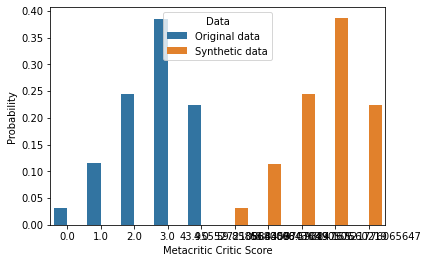

In [ ]:
draw_comparative_hist('Metacritic Critic Score',transformed_data,sample_K2)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


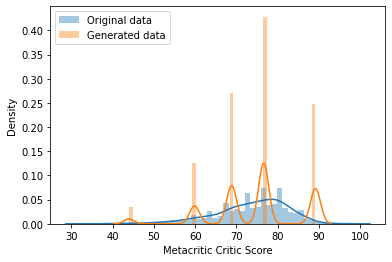

In [ ]:
sns.distplot(source_df['Metacritic Critic Score'], label='Original data')
sns.distplot(sample_K2['Metacritic Critic Score'], label='Generated data')
plt.legend()

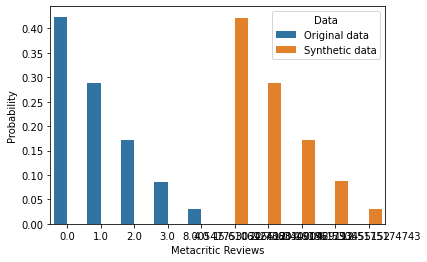

In [ ]:
draw_comparative_hist('Metacritic Reviews',transformed_data,sample_K2)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


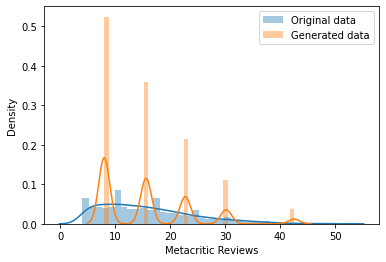

In [ ]:
sns.distplot(source_df['Metacritic Reviews'], label='Original data')
sns.distplot(sample_K2['Metacritic Reviews'], label='Generated data')
plt.legend()

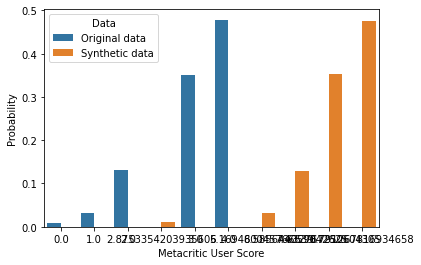

In [ ]:
draw_comparative_hist('Metacritic User Score',transformed_data,sample_K2)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


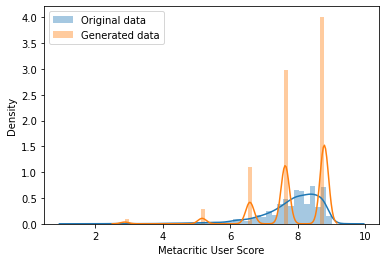

In [ ]:
sns.distplot(source_df['Metacritic User Score'], label='Original data')
sns.distplot(sample_K2['Metacritic User Score'], label='Generated data')
plt.legend()

In [ ]:
# Step 5: Build a Bayesian network for the same set of variables but using 2 chosen algorithms for structural learning

# First was Hill-Climbing with K2
# BicScore

hc_BicScore = HillClimbSearch(transformed_data, scoring_method=BicScore(transformed_data))

best_model_BicScore = hc_BicScore.estimate(black_list=targetlist)

  0%|          | 14/1000000 [00:02<52:28:57,  5.29it/s]


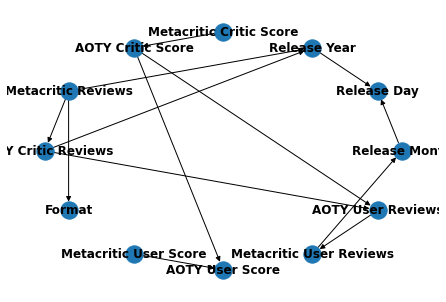

In [ ]:
G_K2 = nx.DiGraph()
G_K2.add_edges_from(best_model_BicScore.edges())
pos = nx.layout.circular_layout(G_K2)
nx.draw(G_K2, pos, with_labels=True,font_weight='bold')

In [ ]:
sample_Bic_score = sampling(best_model_BicScore, transformed_data, 46193)
sample_Bic_score[['Metacritic Critic Score',	'Metacritic Reviews',	'Metacritic User Score',	'Metacritic User Reviews',	'AOTY Critic Score',	'AOTY Critic Reviews',	'AOTY User Score', 'AOTY User Reviews']] = est.inverse_transform(sample_Bic_score[['Metacritic Critic Score',	'Metacritic Reviews',	'Metacritic User Score',	'Metacritic User Reviews',	'AOTY Critic Score',	'AOTY Critic Reviews',	'AOTY User Score', 'AOTY User Reviews']].values)

Generating for node: AOTY User Score: 100%|██████████| 12/12 [00:03<00:00,  3.54it/s]


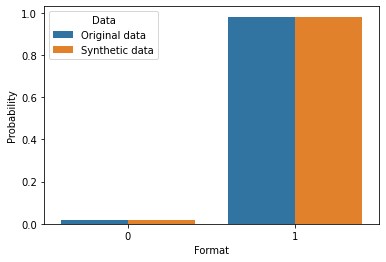

In [ ]:
draw_comparative_hist('Format',transformed_data,sample_Bic_score)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


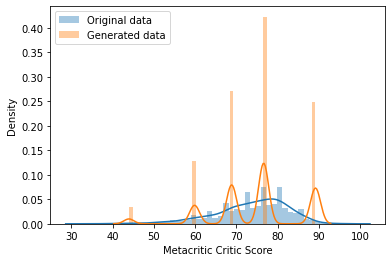

In [ ]:
sns.distplot(source_df['Metacritic Critic Score'], label='Original data')
sns.distplot(sample_Bic_score['Metacritic Critic Score'], label='Generated data')
plt.legend()

In [ ]:
# BDeuScore
hc_BDeuScore = HillClimbSearch(transformed_data, scoring_method=BDeuScore(transformed_data))

best_model_BDeuScore = hc_BDeuScore.estimate(black_list=targetlist)

  0%|          | 14/1000000 [00:02<51:41:05,  5.37it/s]


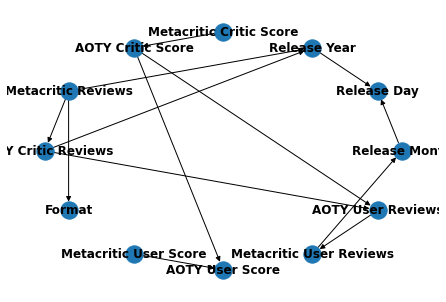

In [ ]:
G_K2 = nx.DiGraph()
G_K2.add_edges_from(best_model_BDeuScore.edges())
pos = nx.layout.circular_layout(G_K2)
nx.draw(G_K2, pos, with_labels=True,font_weight='bold')

In [ ]:
sample_BDeuScore = sampling(best_model_BDeuScore, transformed_data, 46193)
sample_BDeuScore[['Metacritic Critic Score',	'Metacritic Reviews',	'Metacritic User Score',	'Metacritic User Reviews',	'AOTY Critic Score',	'AOTY Critic Reviews',	'AOTY User Score', 'AOTY User Reviews']] = est.inverse_transform(sample_BDeuScore[['Metacritic Critic Score',	'Metacritic Reviews',	'Metacritic User Score',	'Metacritic User Reviews',	'AOTY Critic Score',	'AOTY Critic Reviews',	'AOTY User Score', 'AOTY User Reviews']].values)


Generating for node: AOTY User Score: 100%|██████████| 12/12 [00:03<00:00,  3.53it/s]


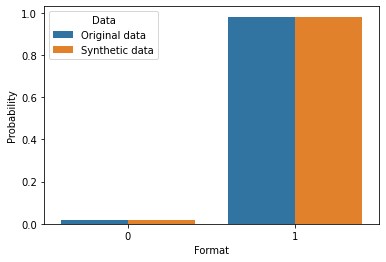

In [ ]:
draw_comparative_hist('Format',transformed_data,sample_BDeuScore)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


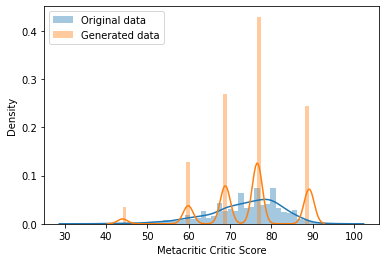

In [ ]:
sns.distplot(source_df['Metacritic Critic Score'], label='Original data')
sns.distplot(sample_BDeuScore['Metacritic Critic Score'], label='Generated data')
plt.legend()

In [ ]:
# Step 6: Analyze a quality of sampled target variables from the point of view of problem statement (e.g. prediction, gap filling, synthetic generation).

def accuracy_params_restoration(bn: BayesianModel, data: pd.DataFrame):
    bn.fit(data)
    result = pd.DataFrame(columns=['Parameter', 'accuracy'])
    bn_infer = VariableElimination(bn)
    for j, param in enumerate(data.columns):
        accuracy = 0
        test_param = data[param]
        test_data = data.drop(columns=param)
        evidence = test_data.to_dict('records')
        predicted_param = []
        for element in evidence:
            prediction = bn_infer.map_query(variables=[param], evidence=element)
            predicted_param.append(prediction[param])
        accuracy = accuracy_score(test_param.values, predicted_param)
        result.loc[j,'Parameter'] = param
        result.loc[j, 'accuracy'] = accuracy
    return result

In [ ]:
accuracy_k2 = accuracy_params_restoration(BayesianModel(best_model_new.edges()), transformed_data)

Выходные данные были обрезаны до нескольких последних строк (5000).
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Eliminat

In [ ]:
accuracy_k2